In [1]:
import datetime as dt
import numpy as np
import pandas as pd
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func, inspect, desc
from sqlalchemy.sql import label

from flask import Flask, jsonify

import matplotlib.pyplot as plt
%matplotlib inline

### Setting up and reflecting hawaii database 

In [2]:
engine = create_engine("sqlite:///hawaii.sqlite")

In [3]:
#reflect base 
Base = automap_base()
#reflect tables
Base.prepare(engine, reflect = True)

In [4]:
# Save reference to the tables
Measurement = Base.classes.measurements
Stations = Base.classes.stations

In [5]:
#create session from python to the database 
session = Session(bind = engine)

#### First look at the database

In [6]:
#using inspector object
inspector = inspect(engine)
inspector.get_table_names()

['measurement', 'measurements', 'station', 'stations']

In [7]:
# columns = inspector.get_columns('measurements')
# for c in columns:
#     print(c['name'], c["type"])

In [8]:

engine.execute('SELECT * FROM stations LIMIT 5').fetchall()


[(1, 'USC00519397', 'WAIKIKI 717.2, HI US', 21.2716, -157.8168, 3.0),
 (2, 'USC00513117', 'KANEOHE 838.1, HI US', 21.4234, -157.8015, 14.6),
 (3, 'USC00514830', 'KUALOA RANCH HEADQUARTERS 886.9, HI US', 21.5213, -157.8374, 7.0),
 (4, 'USC00517948', 'PEARL CITY, HI US', 21.3934, -157.9751, 11.9),
 (5, 'USC00518838', 'UPPER WAHIAWA 874.3, HI US', 21.4992, -158.0111, 306.6)]

In [9]:
engine.execute('SELECT * FROM measurements LIMIT 5').fetchall()


[(1, 'USC00519397', '2010-01-01', 0.08, 65.0),
 (2, 'USC00519397', '2010-01-02', 0.0, 63.0),
 (3, 'USC00519397', '2010-01-03', 0.0, 74.0),
 (4, 'USC00519397', '2010-01-04', 0.0, 76.0),
 (5, 'USC00519397', '2010-01-07', 0.06, 70.0)]

## Precipitation Analysis 
##### Query the data for 12 months of precipitation records 
##### Load the query results into a Pandas DataFrame
##### Sort the DataFrame values by date, and plot 
##### Use Pandas to print the summary statistics for the precipitation data.

In [10]:
results = session.query(Measurement.date, Measurement.prcp).filter(Measurement.date >= '2017-08-01')

In [11]:
data = {'date': [], 'prcp': []}
for row in results:
    data['date'].append(row.date)
    data['prcp'].append(row.prcp)

In [12]:
###set the index to the date column
precipitation_df = pd.DataFrame(data)

In [13]:
precipitation_df.head(10)

,date,prcp
0,2017-08-01,0.02
1,2017-08-02,0.00
2,2017-08-03,0.00
3,2017-08-04,0.02
4,2017-08-05,0.00
5,2017-08-06,0.00
6,2017-08-07,0.00
7,2017-08-08,0.00
8,2017-08-09,0.00
9,2017-08-10,0.00


In [14]:
#reset index to date

precipitation_df.set_index('date').head()


,prcp
date,
2017-08-01,0.02
2017-08-02,0.00
2017-08-03,0.00
2017-08-04,0.02
2017-08-05,0.00


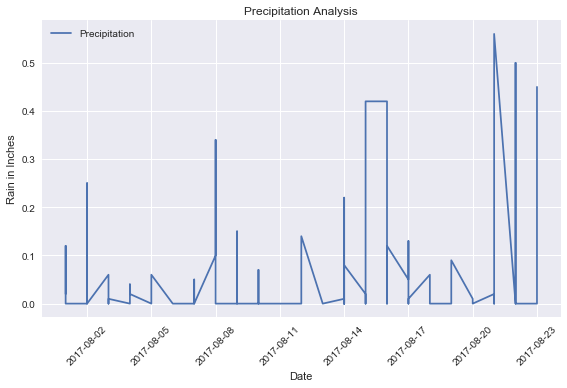

In [15]:
from matplotlib import style
style.use('seaborn')

precipitation_df.plot('date', 'prcp')
plt.xlabel("Date")
plt.ylabel("Rain in Inches")
plt.title("Precipitation Analysis")
plt.legend(["Precipitation"])
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [16]:
precipitation_df.describe()

,prcp
count,81.000000
mean,0.063951
std,0.126023
min,0.000000
25%,0.000000
50%,0.000000
75%,0.060000
max,0.560000


# Temperature Analysis 
### Write a function that accepts a start date and an end date in the format '%Y-%m-%d' 
#### function must return min, max, and avg temperaturess for that range of dates 

In [17]:
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()

print(calc_temps('2017-07-01', '2017-07-15'))

[(69.0, 77.9113924050633, 82.0)]


In [18]:
# calculate the min/max/avg from last year that matches my trip date
trip_arrive = dt.date(2017, 7, 1)
trip_leave = dt.date(2017, 7, 15)
last_year = dt.timedelta(days=365)
temp_avg_lst_year = (calc_temps((trip_arrive-last_year), (trip_leave-last_year)))
print(temp_avg_lst_year)

[(71.0, 76.83544303797468, 81.0)]


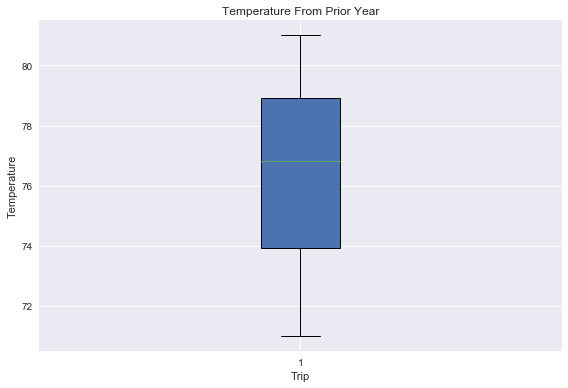

In [19]:
fig, ax = plt.subplots()
x = range(len(temp_avg_lst_year))
ax.boxplot(temp_avg_lst_year, patch_artist=True)
ax.set_title('Temperature From Prior Year')
ax.set_ylabel("Temperature")
ax.set_xlabel("Trip")
fig.tight_layout()
plt.show()

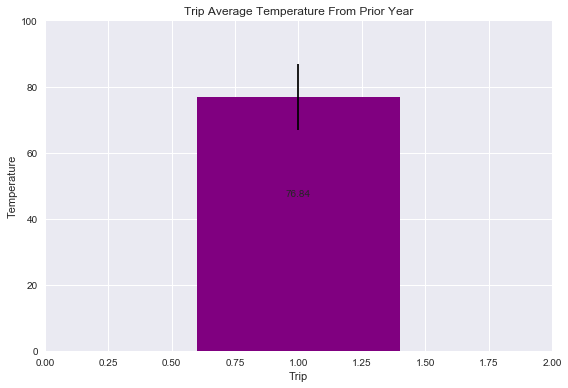

In [20]:
temp_from_prev_year = temp_avg_lst_year[0][2]-temp_avg_lst_year[0][0]
avgtemp = temp_avg_lst_year[0][1]
min_temp = temp_avg_lst_year[0][0]
max_temp = temp_avg_lst_year[0][2]

fig, ax = plt.subplots()
bar_chart = ax.bar(1 , avgtemp, color= 'purple', yerr=temp_from_prev_year)
ax.set_xlabel("Trip")
ax.set_ylabel("Temperature")
ax.set_title("Trip Average Temperature From Prior Year")

def autolabels(rects):
    for rect in rects:
        h=rect.get_height()
        ax.text(rect.get_x() + rect.get_width()/2., .6*h,'%.2f' % float(h) ,ha='center', va='bottom', fontsize=10)

        
    # label the bars 
autolabels(bar_chart)        
plt.ylim(0, 100)
plt.xlim(0,2)
fig.tight_layout()
plt.show()

# Station Analysis 

### Design a query to calculate the total number of stations 
### Design a query to find the most active stations 
### Design a query to retrieve the last 12 months of temperature observation data 


In [21]:
locations = session.query(Measurement).group_by(Measurement.station).count()

In [22]:
print("There are {} stations.".format(locations))

There are 9 stations.


In [23]:
busy_station = session.query(Measurement.station, func.count(Measurement.tobs)).group_by(Measurement.station).\
               order_by(func.count(Measurement.tobs).desc()).all()

busiest = busy_station[0][0]    
print("The busiest Station was",busiest,"with",busy_station[0][1],"weather observations.")
print()
print("Here are all of the Stations (in descending order) with their number of observations:")
for station, count in busy_station:
    print("Station",station,"had",count, "weather observations.")

The busiest Station was USC00519281 with 2772 weather observations.

Here are all of the Stations (in descending order) with their number of observations:
Station USC00519281 had 2772 weather observations.
Station USC00513117 had 2696 weather observations.
Station USC00519397 had 2685 weather observations.
Station USC00519523 had 2572 weather observations.
Station USC00516128 had 2484 weather observations.
Station USC00514830 had 1937 weather observations.
Station USC00511918 had 1932 weather observations.
Station USC00517948 had 683 weather observations.
Station USC00518838 had 342 weather observations.


In [24]:
temperature = session.query(Measurement.station, Measurement.date, Measurement.tobs).\
    filter(Measurement.station == busiest).\
    filter(Measurement.date > last_year).\
    order_by(Measurement.date).all()

In [25]:
temperature[0]

('USC00519281', datetime.date(2010, 1, 1), 70.0)

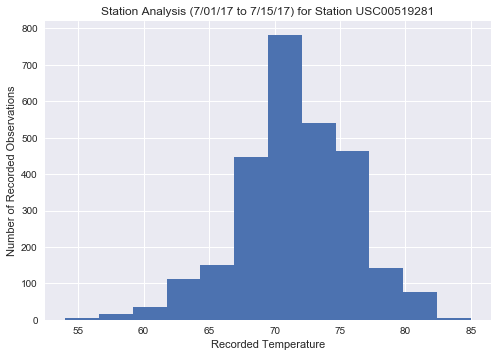

In [26]:
temp_df=pd.DataFrame(temperature)
plt.hist(temp_df['tobs'],12)
plt.xlabel("Recorded Temperature")
plt.ylabel("Number of Recorded Observations")
plt.title("Station Analysis (7/01/17 to 7/15/17) for Station " + busiest)
plt.show()

# Serve data with flask 

In [27]:
app = Flask(__name__)

In [28]:
@app.route("/")
def welcometoweatherapp():
    """Listing of the available API routes"""
    return(
        f"Available Routes: <br/>"
        f"/api/v1.0/precipitation <br/>"
        f"/api/v1.0/stations <br/>"
        f"/api/v1.0/tobs <br/>"
        f"/api/v1.0/<start><br/>"
        f"/api/v1.0/<start>/<end>"
    )

In [29]:
@app.route("/api/v1.0/precipitation")
def precipitation():
    """Query for the dates and temps for the last year"""
    
    # Query the database for dates and tobs
    prcp_results = session.query(Measurement.date, Measurement.tobs).\
    filter(Measurement.date > '2017-07-01').all()
    
    # Create dictionary from row data and append to the list 'all_prcp'
    all_prcp = []
    for prcp in prcp_results:
        prcp_dict = {}
        prcp_dict["Date"] = Measurement.date
        prcp_dict["TOBS"] = Measurement.tobs
        all_prcp.append(prcp_dict)
    return jsonify(all_prcp)

In [30]:
@app.route("/api/v1.0/stations")
def stations():
    """Returns a list of stations from the dataset in JSON format"""
    
    station_results = session.query(Station.station).all()
    
    # Convert the list of tuples into a normal list:
    all_stations = list(np.ravel(station_results))
    
    return jsonify(all_stations)

In [31]:
@app.route("/api/v1.0/tobs")
def tobs():
    """Returns a list of temperature observations from the last year in JSON format """
    
    #Query database for tobs for last year
    tobs_results = session.query(Measurement.tobs).filter(Measurement.date > '2017-01-01').all()
    
    # Convert the list of tuples into normal list:
    all_tobs = list(np.ravel(tobs_results))
    
    return jsonify(all_tobs)

In [32]:
if __name__ == '__main__':
    app.run(debug=True)

UnsupportedOperation: not writable